In [1]:
%%capture
!pip install ht CoolProp fluids xlrd xlwt

In [2]:
%matplotlib widget
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xlwt as xw
lista_data = []
import matplotlib.pyplot as plt
import ht,fluids,os,socket
import CoolProp as cp
from IPython.display import Latex
from prop_fluidos_intercambiadores import fluido_intercambiador
import time,datetime,pint
colores = plt.rcParams['axes.prop_cycle'].by_key()['color']
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
mk = ['o','s','<','d','p']
ureg = pint.UnitRegistry()
psipa = (1*ureg.psi).to('Pa')
psipa = psipa.to_tuple()[0]
from tikzplotlib import save as savetikz
from ipywidgets import interact, interact_manual,interactive,widgets,Layout
from scipy.signal import savgol_filter

## Intercambiador de Calor
#### HIPOTESIS DE CALCULO:


1. Intercambiador de calor a contracorriente de tubos concéntricos


In [3]:
B = pd.read_excel('Densidad y viscosidad diesel.xlsx',thousands=',',sheet_name=1,skiprows=3)
Temps  = pd.to_numeric(B['T(K)'],errors='ignore').to_numpy()
Viscosidad = pd.to_numeric(B['Viscosidad (cp)'],errors='ignore').to_numpy()
Densidad = pd.to_numeric(B['Densidad (g/ml)'],errors='ignore').to_numpy()*1000
D_interno_1 = 0.8366*25.4e-3


## ajuste
P1 = np.polyfit(1/Temps,np.log(Viscosidad),1)
viscosidad_f = np.poly1d(P1)
temperaturas = np.linspace(Temps[0]-10,Temps[-1]+10,100)
P2 = np.polyfit(Temps,Densidad,1)
densidad_f = np.poly1d(P2)

In [4]:
P1,P2

(array([2302.55849485,   -6.61174115]),
 array([-6.94642857e-01,  1.02629170e+03]))

In [5]:
salida_sensor = np.array([3.9,2.39,1.25,0.45,0.244,0.205,0.056,-3.67,-2.36,-1.15,-0.34,-0.12,-0.080,1.25])
velocidades_motor = np.array([-2000,-1500,-1000,-500,-250,-200,0,2000,1500,1000,500,250,200,-1000])
caudales = np.array([-27.3,-20.685,-14.2,-7.588,-3.9,-3.153,0,26.7,20.9,14.24,7.68,4.04,3.3,-14.16])

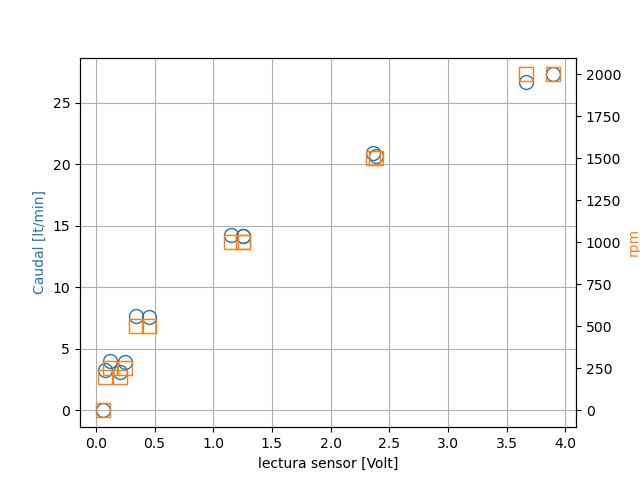

In [6]:
fig,ax = plt.subplots()
ax.plot(np.abs(salida_sensor),np.abs(caudales),'o',fillstyle='none',markersize=10)
axb = ax.twinx()
axb.plot(np.abs(salida_sensor),np.abs(velocidades_motor),'s',color=colores[1],fillstyle='none',markersize=10)
ax.grid()
axb.set_ylabel('rpm')
ax.set_ylabel('Caudal [lt/min]')
ax.set_xlabel('lectura sensor [Volt]')
axb.yaxis.label.set_color(colores[1])
ax.yaxis.label.set_color(colores[0])

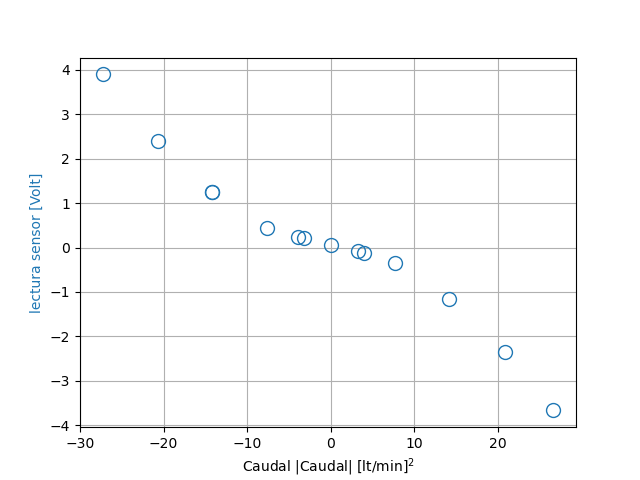

In [7]:
fig,ax = plt.subplots()
G2i = caudales
P1 = np.polyfit(G2i,salida_sensor,1)
sensordp_f = np.poly1d(P1)

G2_s = np.linspace(G2i.min(),G2i.max(),100)
ax.plot(G2i,(salida_sensor),'o',fillstyle='none',markersize=10)
#ax.plot(G2_s,sensordp_f(G2_s))
ax.grid()
ax.set_xlabel('Caudal |Caudal| [lt/min]$^2$')
ax.set_ylabel('lectura sensor [Volt]')
ax.yaxis.label.set_color(colores[0])

In [8]:
A = pd.read_excel('Pruebas diesel 19-08-2022.xlsx',thousands=',')
A = A.drop(A.index[[0,1,2]])

Caudal = pd.to_numeric(A['CORIOLIS_VolFlow'],errors='coerce').to_numpy()/1000
dt = 15/3600
time1 = np.arange(0,len(Caudal)*dt,dt)
indices = np.logical_not(np.isnan(Caudal))
densidad = pd.to_numeric(A['CORIOLIS_Density'],errors='ignore').to_numpy()

TE_s = np.tile(np.zeros_like(Caudal),[12,1])
PT_s = np.tile(np.zeros_like(Caudal),[6,1])
for i in range(10,22):
    TE_s[i-10] = pd.to_numeric(A.iloc[:,i],errors='coerce').to_numpy()
for i in range(1,6):
    PT_s[i-1] = pd.to_numeric(A.iloc[:,i],errors='coerce').to_numpy()
Tchiller_pv, Tchiller_sp = [pd.to_numeric(A.iloc[:,i].to_numpy(),errors='ignore') for i in range(27,29)]
PT_ref= np.array([PTi[:160].mean() for PTi in PT_s])
PT_s = PT_s - np.tile(PT_ref,[len(PT_s[0]),1]).T

In [9]:
A = pd.read_excel('Pruebas diesel 31-08-2022 calib DP y quitar resistencia.xlsx',thousands=',')
A=A.drop(A.index[[0,1,2,3]])
Caudal = pd.to_numeric(A['CORIOLIS_VolFlow'],errors='coerce').to_numpy()/1000
dt = 15/3600
time1 = np.arange(0,len(Caudal)*dt,dt)
indices = np.logical_not(np.isnan(Caudal))
densidad = pd.to_numeric(A['CORIOLIS_Density'],errors='ignore').to_numpy()

TE_s = np.tile(np.zeros_like(Caudal),[12,1])
PT_s = np.tile(np.zeros_like(Caudal),[5,1])
for i in range(10,22):
    TE_s[i-10] = pd.to_numeric(A.iloc[:,i],errors='coerce').to_numpy()
for i in range(1,6):
    PT_s[i-1] = pd.to_numeric(A.iloc[:,i],errors='coerce').to_numpy()
Tchiller_pv, Tchiller_sp = [pd.to_numeric(A.iloc[:,i].to_numpy(),errors='ignore') for i in range(27,29)]

#PT_s = PT_s - np.tile(PT_ref,[len(PT_s[0]),1]).T

dt = 15/3600
time1 = np.arange(0,len(Caudal)*dt,dt)

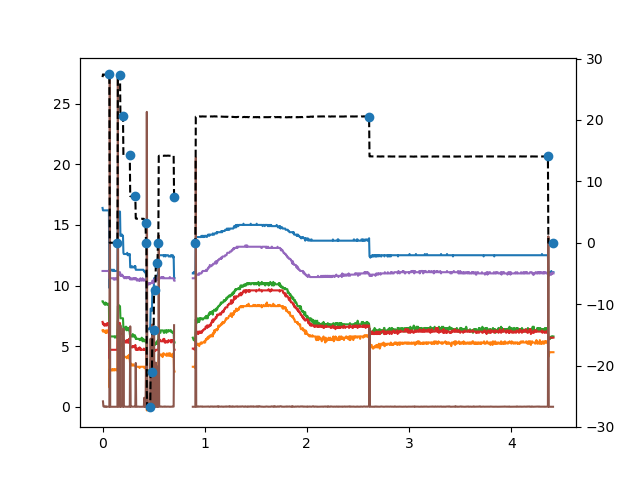

In [10]:
fig,ax = plt.subplots()
ax.plot(time1,PT_s.T);
axb = ax.twinx()
axb.plot(time1,Caudal,'k--')
Caudal2 = np.copy(Caudal)
Caudal2[np.isnan(Caudal)] = 1e3
picos = find_peaks(np.abs(np.diff( Caudal2)),threshold=1)
axb.plot(time1[picos[0]], Caudal[picos[0]],'o')
ax.plot(time1[1:], np.abs(np.diff( Caudal)))

In [11]:
class ensayo:    
    def __init__(self):
        self.indices = [0,0]
        self.caudal = 0
        self.temperatura = 0
        self.presiones_abs = [0,0,0,0,0]
    def data(self,PT_s,TE_s,Caudal):
        self.presiones_abs = PT_s[:,self.indices[0]:self.indices[1]].mean(1)
        self.temperaturas = TE_s[:,self.indices[0]:self.indices[1]].mean(1)
        self.caudal = Caudal[self.indices[0]:self.indices[1]].mean()
        

In [12]:
ni = 0
ensayos = []
for i,picoi in enumerate(picos[0]):
    ensayos.append(ensayo())
    nf = picoi
    ensayos[i].indices = [ni,nf]
    ensayos[i].data(PT_s,TE_s,Caudal)
    ni = nf+1
Caudales_ensayados = []
for i, ensayoi in enumerate(ensayos):
        Caudales_ensayados.append(ensayoi.caudal)
Caudales_ensayados = np.asarray(Caudales_ensayados)


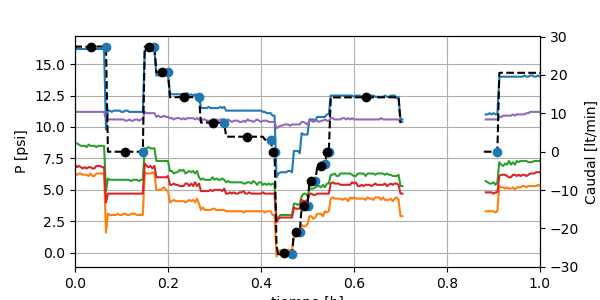

In [13]:
fig,ax = plt.subplots(figsize=(6,3))
ax.plot(time1,PT_s.T);
axb = ax.twinx()
axb.plot(time1,Caudal,'k--')
#ax.set_xlim([0,170])
#ax.plot(np.diff(Caudal))
picos = find_peaks(np.abs(np.diff(Caudal)),threshold=1)
axb.plot(time1[picos[0]], Caudal[picos[0]],'o')
for i, ensayoi in enumerate(ensayos[:15]):
    indicei = int((ensayoi.indices[0]+ensayoi.indices[1])/2)
    axb.plot(time1[indicei], Caudales_ensayados[i],'ko')

    #ax.plot(np.tile(time1[indicei],[5,1]),ensayos[i].presiones_abs,'s',fillstyle='none',markersize=10)
ax.set_xlim([0,1])
ax.set_xlabel('tiempo [h]');
ax.set_ylabel('P [psi]')
axb.set_ylabel('Caudal [lt/min]')
ax.grid();
#savetikz('/home/juan/Documents/Publicaciones/2022_Parafinas/Ensayos-Loop-Agosto-2022/salida_calibracion.tikz')

In [14]:
indice_ref = np.abs(Caudales_ensayados)[:15].argmin()
indice_ref = 1
presiones_ref = ensayos[indice_ref].presiones_abs
presiones_corr = PT_s - np.tile(presiones_ref,[len(Caudal),1]).T


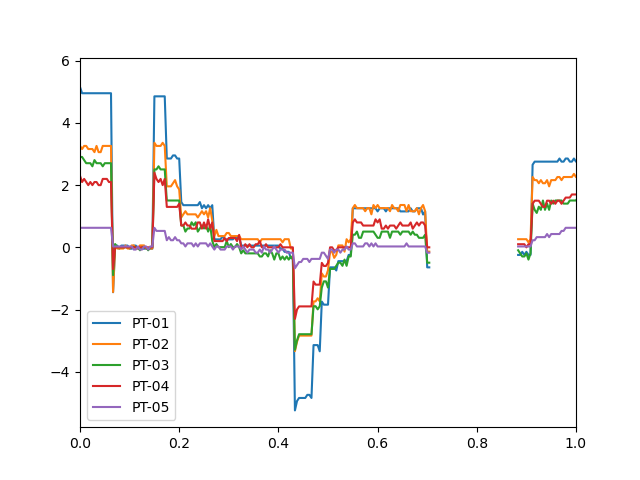

In [15]:
fig,ax = plt.subplots()
for k in range(5):
    ax.plot(time1,presiones_corr[k],label=f'PT-0{k+1:0d}')
ax.set_xlim([0,1])
ax.legend();

Text(0.5, 0, 'tiempo [h]')

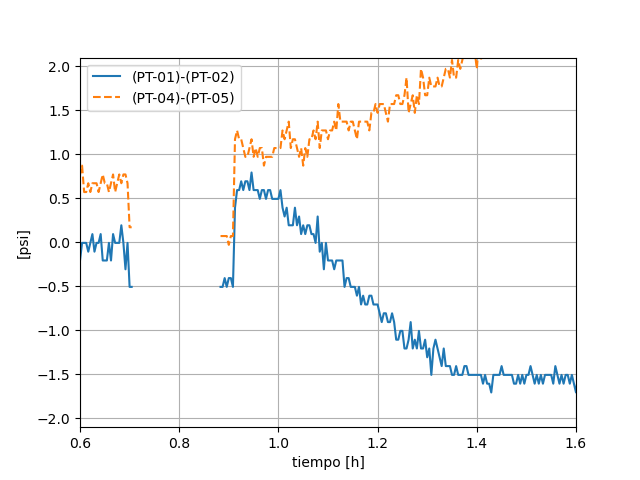

In [16]:
fig,ax = plt.subplots()
ax.plot(time1,presiones_corr[0]-presiones_corr[1],label=f'(PT-01)-(PT-02)')
ax.plot(time1,presiones_corr[3]-presiones_corr[4],label=f'(PT-04)-(PT-05)',linestyle='dashed')
ax.set_xlim([0.6,1.6])
ax.set_ylim([-2.1,2.1])

ax.legend()
ax.grid()
ax.set_ylabel('[psi]');
ax.set_xlabel('tiempo [h]')
#savetikz('/home/juan/Documents/Publicaciones/2022_Parafinas/Ensayos-Loop-Agosto-2022/errores_sensores.tikz')

In [17]:

indices_ensayos = Caudales_ensayados[:15].argsort()
#indices_ensayos = np.delete(indices_ensayos,7)

Longitudes = np.array([6532.7,6532.7+290+1590.7+290,6532.7+(290+1590.7+290)*2,
                       6532.7+(290+1590.7+290)*2+6518.4])/1000
p1,p2,p3,p4,p5,G2 = np.tile(np.zeros_like(Caudales_ensayados[indices_ensayos]),[6,1])
for i, caudal in enumerate(Caudales_ensayados[indices_ensayos]):
    presiones = ensayos[indices_ensayos[i]].presiones_abs -presiones_ref
    G2[i] = caudal
    p1[i],p2[i],p3[i],p4[i],p5[i] = ( presiones[0]-presiones[:5])
    #ax.plot(caudal*np.abs(caudal),p4[i],'o')
pi_s = [p2,p3,p4,p5]
G2s = np.linspace(G2.min(),G2.max(),100)

In [18]:
#perdidas ecuacion Darcy
Tmedia = 13+273
rho = densidad_f(Tmedia)
mu = viscosidad_f(1/Tmedia)/1000
nu = mu/rho
delta_p_5 = np.zeros_like(G2)

delta_p_5b = np.zeros_like(G2s)
for i,G2i in enumerate(G2s):
    Ui = G2i/60*1e-3 / (D_interno_1 **2/4*np.pi)
    Re_i = np.abs(Ui)*D_interno_1/nu
    ff_i = ht.conv_internal.friction_factor(Re_i)
    delta_p_5b[i] = Ui**2*Longitudes[-1]/D_interno_1*0.5*rho*ff_i*np.sign(G2i)


for i,G2i in enumerate(G2):
    Ui = G2i/60*1e-3 / (D_interno_1 **2/4*np.pi)
    Re_i = np.abs(Ui)*D_interno_1/nu
    ff_i = ht.conv_internal.friction_factor(Re_i)
    delta_p_5[i] = Ui**2*Longitudes[-1]/D_interno_1*0.5*rho*ff_i*np.sign(G2i)
    
P1 = np.polyfit(G2,p5,1)
p1_f  = np.poly1d(P1)

P2 = np.polyfit (-caudales*np.abs(caudales), salida_sensor,1)
p2_f = np.poly1d(P2)

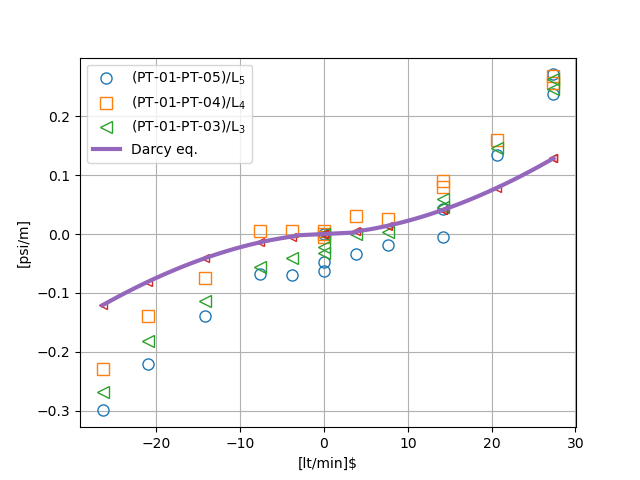

In [19]:

fig,ax = plt.subplots()

for i, Li in enumerate(Longitudes[:3]):
    P1 = np.polyfit(G2,pi_s[i]/Li,1)
    p1_f  = np.poly1d(P1)
    lin, = ax.plot(G2,pi_s[i]/Li,linestyle='',marker=mk[i],markersize=8,fillstyle='none',label=f'(PT-01-PT-0{5-i:0d})/L$_{5-i:0d}$')
   # ax.plot(G2s,p1_f(G2s),color=lin.get_color(),linewidth=0.5)

    
    
    
#lin, = ax.plot(np.abs(G2)**.5*np.sign(G2) ,pi_s[i]/Li,linestyle='',marker=mk[i],markersize=8,fillstyle='none',label=f'(PT-01-PT-0{5-i:0d})/L$_{5-i:0d}$')    
#ax.plot( np.abs(G2)**.5*np.sign(G2),delta_p_5/psipa/Longitudes[-1],fillstyle='none',linestyle='',markersize=8,marker='<',label='Darcy eq.',color='black');

ax.plot( G2,delta_p_5/psipa/Longitudes[-1],fillstyle='none',linestyle='none',marker='<')#,label='Darcy eq.');


ax.plot( G2s,delta_p_5b/psipa/Longitudes[-1],fillstyle='none',linestyle='-',linewidth=3,label='Darcy eq.');
ax.legend()
ax.grid()
ax.set_xlabel('[lt/min]$')
ax.set_ylabel('[psi/m]');
#axb = ax.twinx()
#
#axb.plot((caudales),-salida_sensor,marker='*',linestyle='',fillstyle='none',markersize=15,label='$\Delta p$ sensor')
#axb.set_ylabel('volts');
#axb.legend(loc='lower right');

savetikz('/home/juan/Documents/Publicaciones/2022_Parafinas/Ensayos-Loop-Agosto-2022/difrencia_presiones_abs.tikz')

In [20]:

delta_p_calib = np.zeros_like(caudales)
for i,G2i in enumerate(-caudales):
    if G2i==0:
        G2i=0.0000001
    Ui = G2i/60*1e-3 / (D_interno_1 **2/4*np.pi)
    Re_i = np.abs(Ui)*D_interno_1/nu
    ff_i = ht.conv_internal.friction_factor(Re_i)
    delta_p_calib[i] = Ui**2*Longitudes[-1]/D_interno_1*0.5*rho*ff_i*np.sign(G2i)/psipa

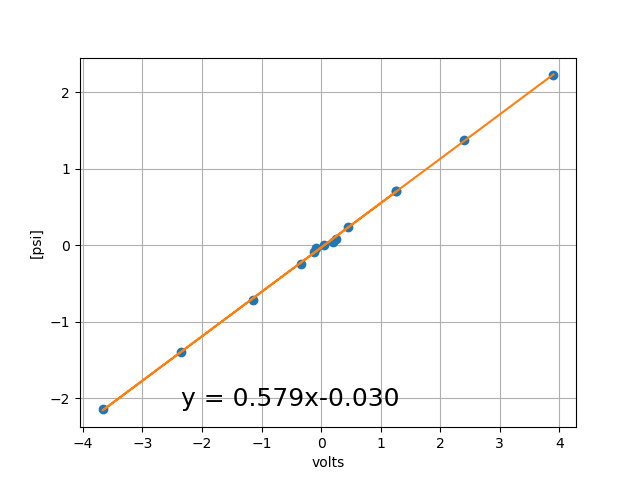

In [21]:
fig,ax = plt.subplots()

ax.plot(salida_sensor,delta_p_calib,'o')
ax.grid()

P1 = np.polyfit(salida_sensor,delta_p_calib,1)
f_ajuste = np.poly1d(P1)
ax.plot(salida_sensor,f_ajuste(salida_sensor))
ax.text(salida_sensor[8],f_ajuste(salida_sensor)[8]-.7,f'y = {P1[0]:.3f}x{P1[1]:.3f}',fontsize=18)
ax.set_xlabel('volts')
ax.set_ylabel('[psi]');
savetikz('/home/juan/Documents/Publicaciones/2022_Parafinas/Ensayos-Loop-Agosto-2022/salida_calibracion_deltap_ajuste.tikz')

In [22]:
P1

array([ 0.57939495, -0.02989016])

 \begin{equation}
	(D_i-2\delta_w)^{5-n}=\frac{2c\rho L}{\Delta p_f}\left(\frac{\mu}{\rho}\right)^n\left(\frac{4Q}{\pi}\right)^{5-n}
\end{equation}

In [23]:
A = pd.read_excel('Pruebas diesel 26-09-2022 WAT diesel.xlsx')
A=A.drop(A.index[[0,1,2,3]])
Caudal = pd.to_numeric(A['CORIOLIS_VolFlow'],errors='coerce').to_numpy()/1000
dt = 15/3600
time1 = np.arange(0,len(Caudal)*dt,dt)
indices = np.logical_not(np.isnan(Caudal))
densidad = pd.to_numeric(A['CORIOLIS_Density'],errors='ignore').to_numpy()

TE_s = np.tile(np.zeros_like(Caudal),[12,1])
PT_s = np.tile(np.zeros_like(Caudal),[5,1])
for i in range(10,22):
    TE_s[i-10] = pd.to_numeric(A.iloc[:,i],errors='coerce').to_numpy()
for i in range(1,6):
    PT_s[i-1] = pd.to_numeric(A.iloc[:,i],errors='coerce').to_numpy()
Tchiller_pv, Tchiller_sp = [pd.to_numeric(A.iloc[:,i].to_numpy(),errors='ignore') for i in range(27,29)]

#PT_s = PT_s - np.tile(PT_ref,[len(PT_s[0]),1]).T

dt = 15/3600
time1 = np.arange(0,len(Caudal)*dt,dt)

In [24]:
B = pd.read_csv('Datos 26092022')
volts = B.iloc[:,0].to_numpy()
dt2= 1
time2 = np.arange(0,dt2*len(volts),dt2)/3600

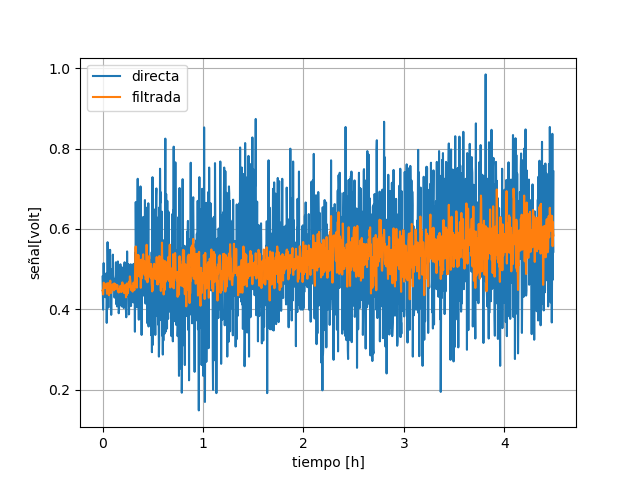

In [25]:
n = 10
fig,ax = plt.subplots()
ax.plot(time2[::n],volts[::n],label='directa')
#ax.plot(time2,savgol_filter(volts,15,3))
ax.plot(time2[::n],savgol_filter(volts,15,1)[::n],label='filtrada')
ax.grid()
#ax.set_xlim([0,1])
ax.legend()
ax.set_ylabel('señal[volt]');
ax.set_xlabel('tiempo [h]')
#axb = ax.twinx()
#axb.plot(time1,Caudal,linewidth=3,color='k')
savetikz('/home/juan/Documents/Publicaciones/2022_Parafinas/Ensayos-Loop-Agosto-2022/señal_dp.tikz')

In [68]:
A = pd.read_excel('Datos diesel + parafina 05-10-2022.xlsx')
A=A.drop(A.index[[0,1,2,3]])
Caudal = pd.to_numeric(A['CORIOLIS_VolFlow'],errors='coerce').to_numpy()/1000
dt = 15/3600
time1 = np.arange(0,len(Caudal)*dt,dt)
indices = np.logical_not(np.isnan(Caudal))
densidad = pd.to_numeric(A['CORIOLIS_Density'],errors='ignore').to_numpy()

TE_s = np.tile(np.zeros_like(Caudal),[12,1])
PT_s = np.tile(np.zeros_like(Caudal),[5,1])
for i in range(10,22):
    TE_s[i-10] = pd.to_numeric(A.iloc[:,i],errors='coerce').to_numpy()
for i in range(1,6):
    PT_s[i-1] = pd.to_numeric(A.iloc[:,i],errors='coerce').to_numpy()
Tchiller_pv, Tchiller_sp = [pd.to_numeric(A.iloc[:,i].to_numpy(),errors='ignore') for i in range(27,29)]

#PT_s = PT_s - np.tile(PT_ref,[len(PT_s[0]),1]).T

dt = 15/3600
time1 = np.arange(0,len(Caudal)*dt,dt)

In [71]:
B = pd.read_csv('Datos 05102022')
volts = B.iloc[:,0].to_numpy()
dt2= 1
time2 = np.arange(0,dt2*len(volts),dt2)/3600

In [105]:
n = 10
fig,ax = plt.subplots()
#ax.plot(time2[::n],volts[::n],label='directa')
#ax.plot(time2,savgol_filter(volts,15,3))
ax.plot(time2[::n],savgol_filter(f_ajuste(volts),15,1)[::n],label='$\Delta p$')
ax.grid()
ax.set_ylim([0,1])

ax.set_ylabel('[psi]');
ax.set_xlabel('tiempo [h]')
axb = ax.twinx()
axb.plot(time1,TE_s[4],linewidth=3,color='k',label= 'TE=05')
ax.legend(loc='center')
axb.legend(loc='upper right')

axb.set_ylabel('[$^\circ$C]');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [106]:
13601/3600

3.7780555555555555